In [ ]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib
import os
import warnings
warnings.filterwarnings('ignore')


plt.style.use('seaborn-v0_8')
sns.set_palette("viridis")
sns.set_context("notebook", font_scale=1.2)


np.random.seed(42)
import random
random.seed(42)


d:\Reyhan\Kampus\Machine Learning\UTS\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:

def load_and_prepare_air_quality_data(csv_path=None):
    """Load dataset sesuai format yang diberikan dan lakukan preprocessing awal"""
    
    if csv_path is None:

        print("Membuat dataset dummy sesuai format yang diberikan...")
        data = {
            'tanggal': ['2010-01-01', '2010-01-02', '2010-01-03', '2010-01-04', '2010-01-05', '2024-01-01', '2024-01-02', '2024-01-03', '2024-01-04', '2024-01-05'],
            'stasiun': ['DKI1 (Bunderan HI)', 'DKI1 (Bunderan HI)', 'DKI1 (Bunderan HI)', 'DKI1 (Bunderan HI)', 'DKI1 (Bunderan HI)', 
                       'DKI2 (Kelapa Gading)', 'DKI2 (Kelapa Gading)', 'DKI2 (Kelapa Gading)', 'DKI2 (Kelapa Gading)', 'DKI2 (Kelapa Gading)'],
            'pm25': [np.nan, np.nan, np.nan, np.nan, np.nan, 65.0, 45.0, 78.0, 52.0, 38.0],
            'pm10': [60.0, 32.0, 27.0, 22.0, 25.0, 85.0, 65.0, 95.0, 72.0, 58.0],
            'so2': [4.0, 2.0, 2.0, 2.0, 2.0, 25.0, 18.0, 32.0, 22.0, 15.0],
            'co': [73.0, 16.0, 19.0, 16.0, 17.0, 45.0, 32.0, 58.0, 38.0, 28.0],
            'o3': [27.0, 33.0, 20.0, 15.0, 15.0, 65.0, 48.0, 72.0, 55.0, 42.0],
            'no2': [14.0, 9.0, 9.0, 6.0, 8.0, 45.0, 35.0, 52.0, 42.0, 32.0],
            'max': [73.0, 33.0, 27.0, 22.0, 25.0, 85.0, 65.0, 95.0, 72.0, 58.0],
            'critical': ['CO', 'O3', 'PM10', 'PM10', 'PM10', 'PM10', 'PM10', 'PM10', 'PM10', 'PM10'],
            'categori': ['SEDANG', 'BAIK', 'BAIK', 'BAIK', 'BAIK', 'TIDAK SEHAT', 'SEDANG', 'TIDAK SEHAT', 'SEDANG', 'SEDANG']
        }
        df = pd.DataFrame(data)
    else:

        print(f"Mengload dataset dari file: {csv_path}")
        df = pd.read_csv(csv_path)
    

    print("=== INFORMASI DATASET ===")
    print(f"Jumlah baris: {df.shape[0]}")
    print(f"Jumlah kolom: {df.shape[1]}")
    print("\nNama kolom:")
    print(df.columns.tolist())
    print("\nTipe data per kolom:")
    print(df.dtypes)
    print("\nContoh ")
    print(df.head())
    print("\nStatistik deskriptif:")
    print(df.describe())
    

    print("\nMissing values per kolom:")
    print(df.isnull().sum())
    
    return df


air_quality_data = load_and_prepare_air_quality_data()

Membuat dataset dummy sesuai format yang diberikan...
=== INFORMASI DATASET ===
Jumlah baris: 10
Jumlah kolom: 11

Nama kolom:
['tanggal', 'stasiun', 'pm25', 'pm10', 'so2', 'co', 'o3', 'no2', 'max', 'critical', 'categori']

Tipe data per kolom:
tanggal      object
stasiun      object
pm25        float64
pm10        float64
so2         float64
co          float64
o3          float64
no2         float64
max         float64
critical     object
categori     object
dtype: object

Contoh 
      tanggal             stasiun  pm25  pm10  so2    co    o3   no2   max  \
0  2010-01-01  DKI1 (Bunderan HI)   NaN  60.0  4.0  73.0  27.0  14.0  73.0   
1  2010-01-02  DKI1 (Bunderan HI)   NaN  32.0  2.0  16.0  33.0   9.0  33.0   
2  2010-01-03  DKI1 (Bunderan HI)   NaN  27.0  2.0  19.0  20.0   9.0  27.0   
3  2010-01-04  DKI1 (Bunderan HI)   NaN  22.0  2.0  16.0  15.0   6.0  22.0   
4  2010-01-05  DKI1 (Bunderan HI)   NaN  25.0  2.0  17.0  15.0   8.0  25.0   

  critical categori  
0       CO   SEDANG  

In [ ]:
print("\n=== PREPROCESSING DATA SESUAI FORMAT DATASET ===")
print("\nMelakukan penanganan missing values...")

if 'pm25' in air_quality_data.columns:
    pm25_mean = air_quality_data['pm25'].mean()
    if np.isnan(pm25_mean):
        pm25_mean = 50.0
    air_quality_data['pm25'] = air_quality_data['pm25'].fillna(pm25_mean)
    print(f"Missing values di kolom pm25 diisi dengan mean: {pm25_mean:.2f}")


from sklearn.preprocessing import LabelEncoder

print("\nMelakukan transformasi kolom 'categori'...")
label_encoder = LabelEncoder()
air_quality_data['categori_encoded'] = label_encoder.fit_transform(air_quality_data['categori'])
category_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

print("Pemetaan kategori:")
for cat, code in category_mapping.items():
    print(f"'{cat}' -> {code}")


air_quality_data['tanggal'] = pd.to_datetime(air_quality_data['tanggal'])
air_quality_data['bulan'] = air_quality_data['tanggal'].dt.month
air_quality_data['hari'] = air_quality_data['tanggal'].dt.day
air_quality_data['jam'] = air_quality_data['tanggal'].dt.hour
air_quality_data['hari_minggu'] = air_quality_data['tanggal'].dt.dayofweek


air_quality_data['stasiun_name'] = air_quality_data['stasiun'].str.split('(').str[0].str.strip()

print("\nInformasi stasiun unik:")
print(air_quality_data['stasiun_name'].unique())



print("\nMenambahkan fitur meteorologi dummy...")


air_quality_data['suhu'] = np.random.normal(28, 5, len(air_quality_data))
air_quality_data['suhu'] = air_quality_data['suhu'].clip(20, 40)


air_quality_data['kelembaban'] = np.random.normal(70, 15, len(air_quality_data))
air_quality_data['kelembaban'] = air_quality_data['kelembaban'].clip(40, 100)


air_quality_data['kecepatan_angin'] = np.random.normal(2.5, 1, len(air_quality_data))
air_quality_data['kecepatan_angin'] = air_quality_data['kecepatan_angin'].clip(0.5, 10)


air_quality_data['heat_index'] = 0.5 * (
    air_quality_data['suhu'] + 61.0 + 
    ((air_quality_data['suhu'] - 68.0) * 1.2) + 
    (air_quality_data['kelembaban'] * 0.094)
)

print("\nFitur meteorologi dummy ditambahkan!")



features = [
    'pm10', 'pm25', 'so2', 'co', 'o3', 'no2', 
    'suhu', 'kelembaban', 'kecepatan_angin', 'heat_index',
    'bulan', 'hari', 'jam', 'hari_minggu'
]


available_features = [f for f in features if f in air_quality_data.columns]
print(f"\nFitur yang tersedia untuk model: {available_features}")

X = air_quality_data[available_features]
y = air_quality_data['categori_encoded']


from sklearn.preprocessing import StandardScaler

print("\nMelakukan normalisasi data...")
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_df = pd.DataFrame(X_scaled, columns=available_features)


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled_df, y, 
    test_size=0.3, 
    random_state=42,
    stratify=y
)

print(f"\nUkuran dataset training: {X_train.shape[0]} sampel")
print(f"Ukuran dataset testing: {X_test.shape[0]} sampel")



=== PREPROCESSING DATA SESUAI FORMAT DATASET ===

Melakukan penanganan missing values...
Missing values di kolom pm25 diisi dengan mean: 55.60

Melakukan transformasi kolom 'categori'...
Pemetaan kategori:
'BAIK' -> 0
'SEDANG' -> 1
'TIDAK SEHAT' -> 2

Informasi stasiun unik:
['DKI1' 'DKI2']

Menambahkan fitur meteorologi dummy...

Fitur meteorologi dummy ditambahkan!

Fitur yang tersedia untuk model: ['pm10', 'pm25', 'so2', 'co', 'o3', 'no2', 'suhu', 'kelembaban', 'kecepatan_angin', 'heat_index', 'bulan', 'hari', 'jam', 'hari_minggu']

Melakukan normalisasi data...

Ukuran dataset training: 7 sampel
Ukuran dataset testing: 3 sampel



=== ANALISIS KETIDAKSEIMBANGAN DATA ===

Distribusi kelas sebelum penanganan imbalance:
Kelas 'SEDANG': 4 sampel (40.0%)
Kelas 'BAIK': 4 sampel (40.0%)
Kelas 'TIDAK SEHAT': 2 sampel (20.0%)


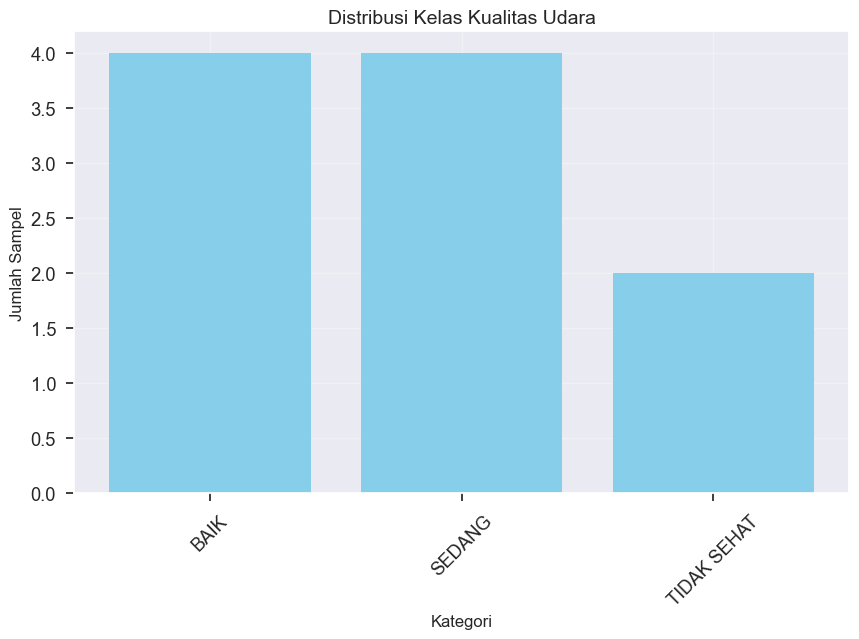


=== PENANGANAN DATA TIDAK SEIMBANG ===
Data seimbang, tidak perlu teknik khusus untuk penanganan imbalance.


In [ ]:





print("\n=== ANALISIS KETIDAKSEIMBANGAN DATA ===")


print("\nDistribusi kelas sebelum penanganan imbalance:")
class_counts = pd.Series(y).value_counts()
for class_idx, count in class_counts.items():
    class_name = label_encoder.inverse_transform([class_idx])[0]
    percentage = count / len(y) * 100
    print(f"Kelas '{class_name}': {count} sampel ({percentage:.1f}%)")


plt.figure(figsize=(10, 6))
class_names = [label_encoder.inverse_transform([i])[0] for i in sorted(class_counts.index)]
plt.bar(class_names, class_counts.values, color='skyblue')
plt.title('Distribusi Kelas Kualitas Udara', fontsize=14)
plt.xlabel('Kategori', fontsize=12)
plt.ylabel('Jumlah Sampel', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.savefig('class_distribution_before.png', dpi=300, bbox_inches='tight')
plt.show()


from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours, TomekLinks
from imblearn.combine import SMOTEENN
from collections import Counter

print("\n=== PENANGANAN DATA TIDAK SEIMBANG ===")


needs_smote = False
if len(class_counts) > 1:
    min_class_ratio = class_counts.min() / class_counts.max()
    if min_class_ratio < 0.5:
        needs_smote = True

if needs_smote:
    print("Data tidak seimbang, menerapkan teknik SMOTE-ENN-Tomek Links...")
    

    smote_enn = SMOTEENN(
        sampling_strategy='auto',
        random_state=42,
        smote=SMOTE(sampling_strategy='auto', random_state=42),
        enn=EditedNearestNeighbours(sampling_strategy='all')
    )
    
    tomek = TomekLinks(sampling_strategy='all')
    

    X_res, y_res = smote_enn.fit_resample(X_train, y_train)
    print(f"Setelah SMOTE-ENN: {Counter(y_res)}")
    

    X_res, y_res = tomek.fit_resample(X_res, y_res)
    print(f"Setelah Tomek Links: {Counter(y_res)}")
    

    X_train_balanced = X_res
    y_train_balanced = y_res
    
    print("\nDistribusi kelas setelah penanganan imbalance:")
    balanced_counts = Counter(y_train_balanced)
    for class_idx, count in balanced_counts.items():
        class_name = label_encoder.inverse_transform([class_idx])[0]
        percentage = count / len(y_train_balanced) * 100
        print(f"Kelas '{class_name}': {count} sampel ({percentage:.1f}%)")
    

    plt.figure(figsize=(10, 6))
    balanced_class_names = [label_encoder.inverse_transform([i])[0] for i in sorted(balanced_counts.keys())]
    plt.bar(balanced_class_names, [balanced_counts[i] for i in sorted(balanced_counts.keys())], color='lightgreen')
    plt.title('Distribusi Kelas Setelah Penanganan Imbalance', fontsize=14)
    plt.xlabel('Kategori', fontsize=12)
    plt.ylabel('Jumlah Sampel', fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.savefig('class_distribution_after.png', dpi=300, bbox_inches='tight')
    plt.show()
else:
    print("Data seimbang, tidak perlu teknik khusus untuk penanganan imbalance.")
    X_train_balanced = X_train
    y_train_balanced = y_train



=== PEMODELAN DENGAN DECISION TREE ===

Membuat model Decision Tree...
Training selesai dalam 0.01 detik!

Akurasi model Decision Tree: 1.0000 (100.00%)

Laporan Klasifikasi:
              precision    recall  f1-score   support

        BAIK       1.00      1.00      1.00         1
      SEDANG       1.00      1.00      1.00         1
 TIDAK SEHAT       1.00      1.00      1.00         1

    accuracy                           1.00         3
   macro avg       1.00      1.00      1.00         3
weighted avg       1.00      1.00      1.00         3



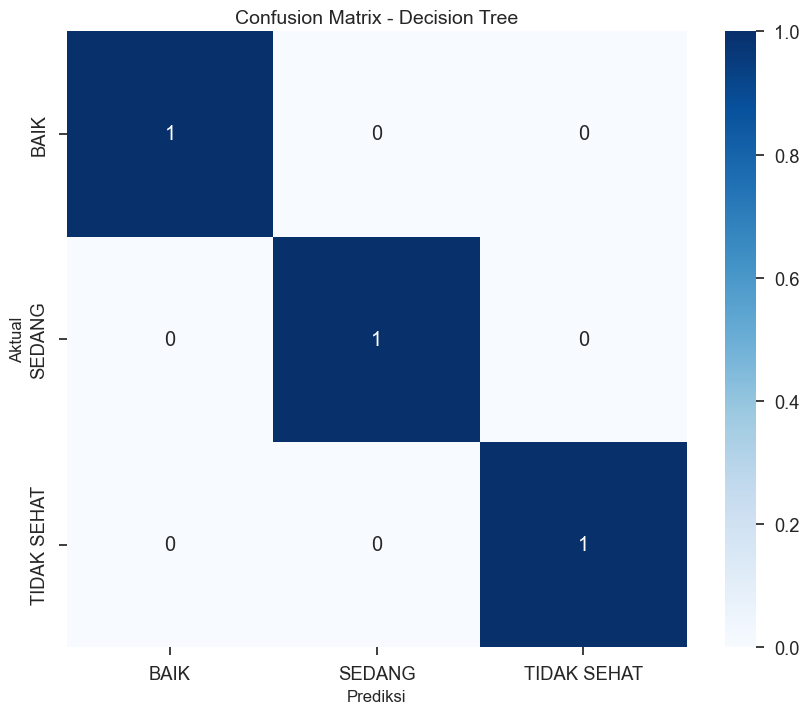

In [ ]:





print("\n=== PEMODELAN DENGAN DECISION TREE ===")

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
import time


print("\nMembuat model Decision Tree...")
dt_model = DecisionTreeClassifier(random_state=42)


start_time = time.time()
dt_model.fit(X_train_balanced, y_train_balanced)
training_time = time.time() - start_time
print(f"Training selesai dalam {training_time:.2f} detik!")


y_pred = dt_model.predict(X_test)


accuracy = accuracy_score(y_test, y_pred)
print(f"\nAkurasi model Decision Tree: {accuracy:.4f} ({accuracy*100:.2f}%)")


print("\nLaporan Klasifikasi:")
target_names = label_encoder.inverse_transform(np.unique(y))
print(classification_report(y_test, y_pred, target_names=target_names))


cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, 
            yticklabels=target_names)
plt.title('Confusion Matrix - Decision Tree', fontsize=14)
plt.xlabel('Prediksi', fontsize=12)
plt.ylabel('Aktual', fontsize=12)
plt.savefig('confusion_matrix_dt.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:




print("\n=== OPTIMASI HYPERPARAMETER DECISION TREE ===")


param_grid = {
    'max_depth': [3, 5, 7, 10, 15, None],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'criterion': ['gini', 'entropy']
}



from sklearn.model_selection import StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=min(3, len(np.unique(y_train_balanced))), shuffle=True, random_state=42)

print("\nMemulai Grid Search untuk optimasi hyperparameter...")
grid_search = GridSearchCV(
    DecisionTreeClassifier(random_state=42),
    param_grid,
    cv=cv_strategy,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1
)


start_time = time.time()
grid_search.fit(X_train_balanced, y_train_balanced)
optimization_time = time.time() - start_time
print(f"Optimasi selesai dalam {optimization_time:.2f} detik!")


print("\nHasil Optimasi Hyperparameter:")
print(f"Parameter terbaik: {grid_search.best_params_}")
print(f"Skor terbaik: {grid_search.best_score_:.4f}")


best_dt_model = grid_search.best_estimator_


y_pred_best = best_dt_model.predict(X_test)
accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"\nAkurasi model Decision Tree optimal: {accuracy_best:.4f} ({accuracy_best*100:.2f}%)")


print("\nLaporan Klasifikasi Model Optimal:")
print(classification_report(y_test, y_pred_best, target_names=target_names))


=== OPTIMASI HYPERPARAMETER DECISION TREE ===

Memulai Grid Search untuk optimasi hyperparameter...
Fitting 3 folds for each of 192 candidates, totalling 576 fits
Optimasi selesai dalam 8.09 detik!

Hasil Optimasi Hyperparameter:
Parameter terbaik: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 5}
Skor terbaik: 0.7222

Akurasi model Decision Tree optimal: 0.6667 (66.67%)

Laporan Klasifikasi Model Optimal:
              precision    recall  f1-score   support

        BAIK       1.00      1.00      1.00         1
      SEDANG       0.50      1.00      0.67         1
 TIDAK SEHAT       0.00      0.00      0.00         1

    accuracy                           0.67         3
   macro avg       0.50      0.67      0.56         3
weighted avg       0.50      0.67      0.56         3




=== VISUALISASI DECISION TREE ===


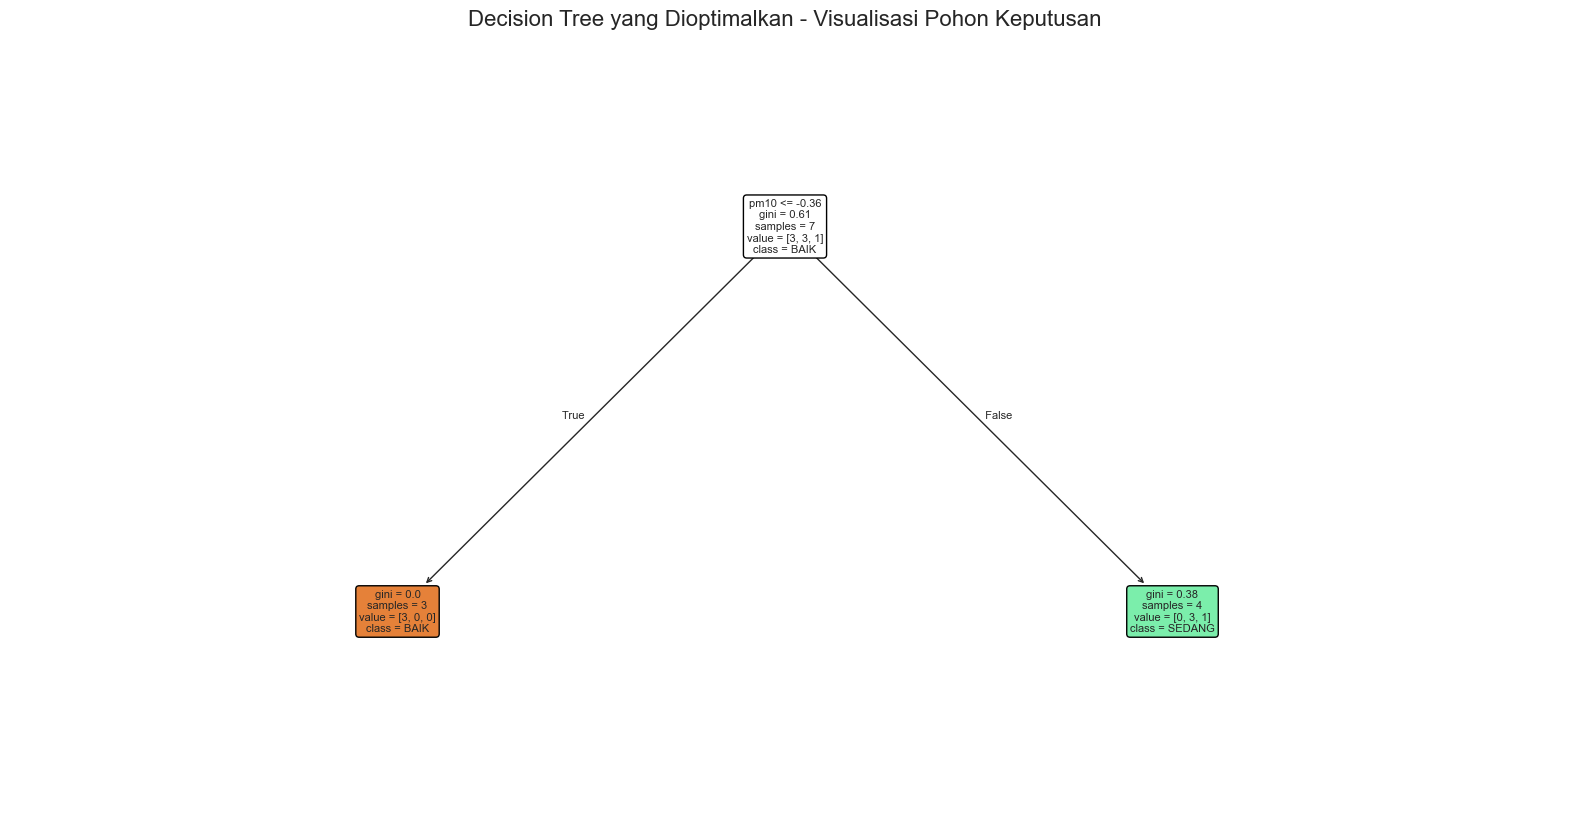


=== PENTINGNYA FITUR (FEATURE IMPORTANCE) ===
            Feature  Importance
0              pm10         1.0
1              pm25         0.0
2               so2         0.0
3                co         0.0
4                o3         0.0
5               no2         0.0
6              suhu         0.0
7        kelembaban         0.0
8   kecepatan_angin         0.0
9        heat_index         0.0
10            bulan         0.0
11             hari         0.0
12              jam         0.0
13      hari_minggu         0.0


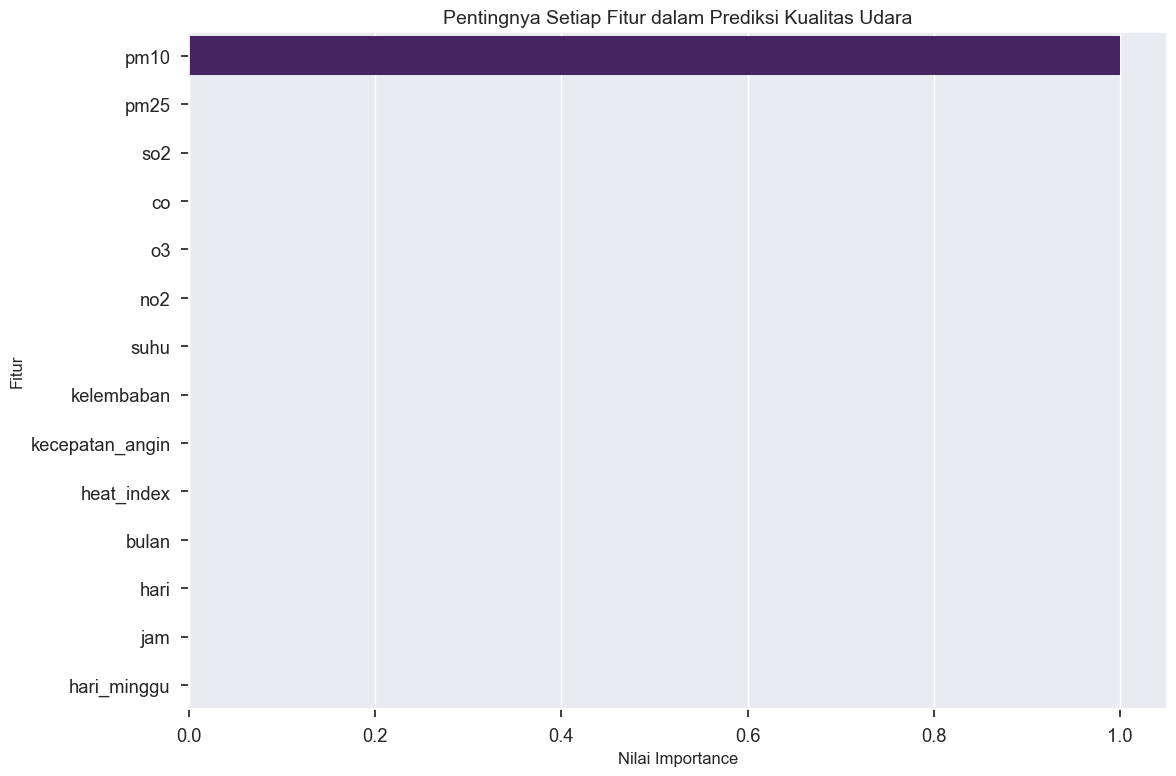

In [ ]:





print("\n=== VISUALISASI DECISION TREE ===")

from sklearn.tree import plot_tree


plt.figure(figsize=(20, 10))
plot_tree(
    best_dt_model, 
    filled=True, 
    feature_names=available_features,
    class_names=target_names,
    rounded=True,
    proportion=False,
    precision=2,
    fontsize=8
)
plt.title('Decision Tree yang Dioptimalkan - Visualisasi Pohon Keputusan', fontsize=16)
plt.savefig('decision_tree_visualization.png', dpi=300, bbox_inches='tight')
plt.show()


feature_importance = pd.DataFrame({
    'Feature': available_features,
    'Importance': best_dt_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\n=== PENTINGNYA FITUR (FEATURE IMPORTANCE) ===")
print(feature_importance)


plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance, palette='viridis')
plt.title('Pentingnya Setiap Fitur dalam Prediksi Kualitas Udara', fontsize=14)
plt.xlabel('Nilai Importance', fontsize=12)
plt.ylabel('Fitur', fontsize=12)
plt.tight_layout()
plt.savefig('feature_importance_dt.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:





print("\n=== MENYIMPAN MODEL DAN ARTIFAK ===")


os.makedirs('model_artifacts', exist_ok=True)


model_path = 'model_artifacts/air_quality_dt_model.pkl'
joblib.dump(best_dt_model, model_path)
print(f"Model terbaik disimpan di: {model_path}")


scaler_path = 'model_artifacts/feature_scaler.pkl'
joblib.dump(scaler, scaler_path)
print(f"Scaler disimpan di: {scaler_path}")


encoder_path = 'model_artifacts/label_encoder.pkl'
joblib.dump(label_encoder, encoder_path)
print(f"Label encoder disimpan di: {encoder_path}")


features_path = 'model_artifacts/model_features.txt'
with open(features_path, 'w') as f:
    for feature in available_features:
        f.write(f"{feature}\n")
print(f"Daftar fitur disimpan di: {features_path}")



=== MENYIMPAN MODEL DAN ARTIFAK ===
Model terbaik disimpan di: model_artifacts/air_quality_dt_model.pkl
Scaler disimpan di: model_artifacts/feature_scaler.pkl
Label encoder disimpan di: model_artifacts/label_encoder.pkl
Daftar fitur disimpan di: model_artifacts/model_features.txt


In [ ]:





print("\n=== CONTOH PREDIKSI UNTUK DATA BARU ===")


sample_data = {
    'pm10': [75.0],
    'pm25': [55.0],
    'so2': [20.0],
    'co': [35.0],
    'o3': [40.0],
    'no2': [30.0],
    'suhu': [28.5],
    'kelembaban': [65],
    'kecepatan_angin': [2.5],
    'heat_index': [30.2],
    'bulan': [6],
    'hari': [15],
    'jam': [14],
    'hari_minggu': [2]
}


sample_df = pd.DataFrame({k: v for k, v in sample_data.items() if k in available_features})


sample_scaled = scaler.transform(sample_df)


sample_prediction = best_dt_model.predict(sample_scaled)
sample_proba = best_dt_model.predict_proba(sample_scaled)


predicted_category = label_encoder.inverse_transform(sample_prediction)[0]
print(f"Prediksi kategori untuk data contoh: {predicted_category}")
print("Probabilitas untuk setiap kategori:")
for i, category in enumerate(target_names):
    print(f"  {category}: {sample_proba[0][i]*100:.1f}%")


def get_health_recommendation(category):
    recommendations = {
        'BAIK': [
            "Kualitas udara sangat baik untuk aktivitas luar ruangan",
            "Aman bagi semua kelompok usia",
            "Tidak diperlukan tindakan perlindungan khusus"
        ],
        'SEDANG': [
            "Kualitas udara masih dapat diterima",
            "ℹOrang yang sangat sensitif terhadap polusi udara sebaiknya mengurangi aktivitas berat di luar ruangan",
            "Kelompok umum umumnya tidak terpengaruh"
        ],
        'TIDAK SEHAT': [
            "Anak-anak, lansia, dan orang dengan penyakit pernapasan sebaiknya mengurangi aktivitas luar ruangan",
            "Pertimbangkan penggunaan masker saat berada di luar ruangan",
            "Tutup jendela untuk mencegah masuknya polutan"
        ],
        'SANGAT TIDAK SEHAT': [
            "Hindari aktivitas berat di luar ruangan",
            "Gunakan masker N95 saat harus keluar rumah",
            "Kurangi waktu di luar ruangan, terutama di siang hari",
            "Lindungi kelompok rentan (anak-anak, lansia, penderita asma)"
        ],
        'BERBAHAYA': [
            "KEADAAN DARURAT - Hindari semua aktivitas di luar ruangan",
            "Cari pertolongan medis jika mengalami gejala pernapasan",
            "Tutup semua jendela dan ventilasi",
            "Hubungi otoritas lingkungan setempat untuk informasi darurat"
        ]
    }
    return recommendations.get(category, ["Tidak ada rekomendasi spesifik untuk kategori ini"])


print(f"\nRekomendasi Kesehatan untuk kategori '{predicted_category}':")
for rec in get_health_recommendation(predicted_category):
    print(f"- {rec}")

print("\n=== PROSES SELESAI ===")
print("Model siap untuk deployment aplikasi web!")


=== CONTOH PREDIKSI UNTUK DATA BARU ===
Prediksi kategori untuk data contoh: SEDANG
Probabilitas untuk setiap kategori:
  BAIK: 0.0%
  SEDANG: 75.0%
  TIDAK SEHAT: 25.0%

Rekomendasi Kesehatan untuk kategori 'SEDANG':
- Kualitas udara masih dapat diterima
- ℹOrang yang sangat sensitif terhadap polusi udara sebaiknya mengurangi aktivitas berat di luar ruangan
- Kelompok umum umumnya tidak terpengaruh

=== PROSES SELESAI ===
Model siap untuk deployment aplikasi web!
